# Fine tuning and Custom realization of an image classifier
### CVIP exam project by Casadei Edoardo and Gaspari Riccardo

The step-by-step description of the project is described on the other notebook.

Here we are going to explain the steps done differently from the other solution, then the final considerations and comparisons between the two models will be discussed in the other notebook.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Fixed random seed for repeatability.
seed = 21
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
import sys
# Check the versions of the environment
print("Python version")
print(sys.version)
print("TensorFlow version")
print(tf.__version__)
print("Keras version")
print(keras.__version__)


Python version
3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
TensorFlow version
2.4.0
Keras version
2.4.0


In [3]:
# Check the usage of the GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 976519668527061628
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10790035776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2773564618979672486
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
]


In [4]:
# Labels mapping
labels = {
            0 : "African Leopard",
            1 : "Caracal",
            2 : "Cheetah",
            3 : "Clouded Leopard",
            4 : "Jaguar",
            5 : "Lions",
            6 : "Ocelot",
            7 : "Puma",
            8 : "Snow Leopard",
            9 : "Tiger"
        }

# Set a default image size
image_size = (224, 224)

**OBS**: $(224,224)$ is the default image size for ResNet50

In [5]:
def load_and_resize_image(image_path, size):

    # Load the image
    img = cv2.imread(image_path)
    
    # Resize the image
    img_resized = cv2.resize(img, size)
    
    # Convert the image to a numpy array and return it
    return np.array(img_resized)


In [6]:
def load_data(data_dir):
    
    # Get the list of class directories
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # Initialize lists to hold images and labels
    x = []
    y = []
    
    (img_width, img_height) = image_size
    
    # Iterate over the class directories
    for i, class_dir in enumerate(class_dirs):
        # Get the list of image files in this directory
        image_files = [f for f in os.listdir(os.path.join(data_dir, class_dir))]
    
        # Iterate over the image files
        for image_file in image_files:
            # Define the path to the image file
            image_path = os.path.join(data_dir, class_dir, image_file)
            
            # Load and resize the image
            img = load_and_resize_image(image_path, (img_width, img_height))
    
            x.append(img)
            y.append(i)

    x = np.array(x)
    y = np.array(y)
    # Print the number of elements of the DataSet
    print(f"{x.shape[0]} images loaded")
    
    # Convert lists to numpy arrays
    return (x, y)

In [7]:
(X_train, y_train) = load_data('C:/Users/ricig/Desktop/archive_cats/train')
(X_test, y_test) = load_data('C:/Users/ricig/Desktop/archive_cats/test')
(X_val, y_val) = load_data('C:/Users/ricig/Desktop/archive_cats/valid')

print(f"The Training images are in the range [{X_train.min()},{X_train.max()}].")
print(f"The Test images are in the range [{X_test.min()},{X_test.max()}].")
print(f"The Validation images are in the range [{X_val.min()},{X_val.max()}].")

print(f"The Training Set contains {X_train.shape[0]} elements")
print(f"The Validation Set contains {X_val.shape[0]} elements")
print(f"The Test Set contains {X_test.shape[0]} elements")

2337 images loaded
50 images loaded
50 images loaded
The Training images are in the range [0,255].
The Test images are in the range [0,255].
The Validation images are in the range [0,255].
The Training Set contains 2337 elements
The Validation Set contains 50 elements
The Test Set contains 50 elements


In [8]:

# Create a data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
])

def augment_image(img):

    img = tf.expand_dims(img, axis=0)

    # Apply the data augmentation
    img = data_augmentation(img)

    img = tf.squeeze(img, axis=0)

    return img

# Apply the augmentation function to each image in X_train
X_train = [augment_image(image) for _ in range(4) for image in X_train]
y_train = [label for _ in range(4) for label in y_train]

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"The Augmented Training Set contains {X_train.shape[0]} elements")
print(y_train.shape[0])
print(f"The range of the X_train's images is [{X_train.min()},{X_train.max()}].")

The Augmented Training Set contains 9348 elements
9348
The range of the X_train's images is [0,255].


In [9]:
# Data Normalization
X_train = X_train.astype('float') / X_train.max()
print(f"The new range of the X_train's images is [{X_train.min()},{X_train.max()}].")
X_val = X_val.astype('float') / X_val.max()
print(f"The new range of the X_val's images is [{X_val.min()},{X_val.max()}].")
X_test = X_test.astype('float') / X_test.max()
print(f"The new range of the X_test's images is [{X_test.min()},{X_test.max()}].")

The new range of the X_train's images is [0.0,1.0].
The new range of the X_val's images is [0.0,1.0].
The new range of the X_test's images is [0.0,1.0].


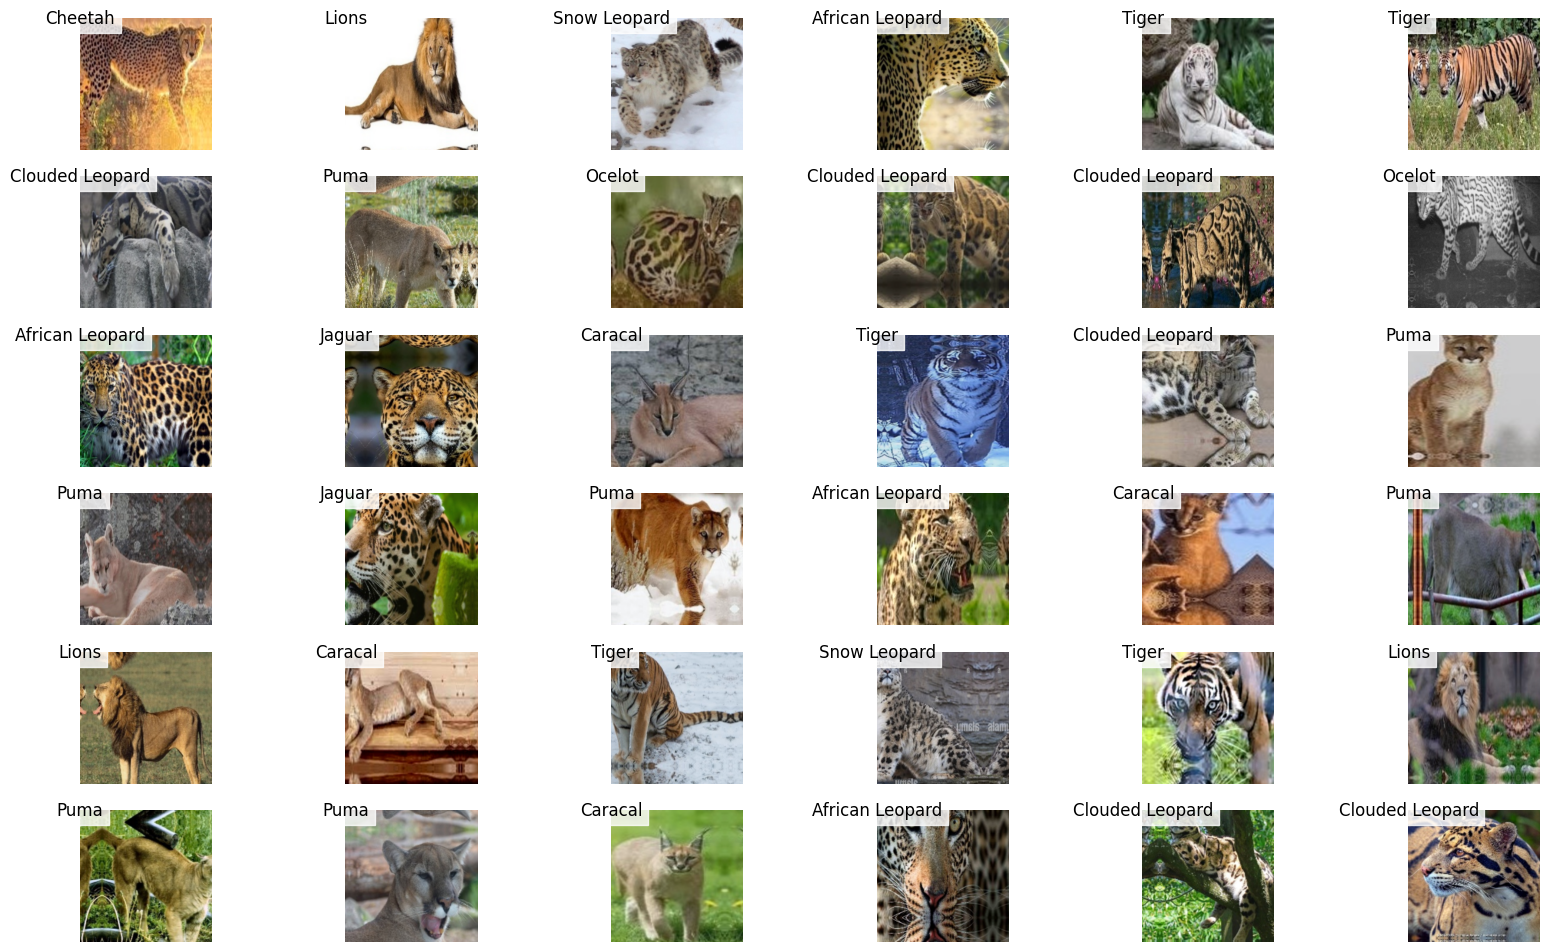

In [10]:
# Check some images
fig, ax = plt.subplots(6, 6, figsize=(20, 12))
ax = ax.ravel()

for i in range(36):
    rand_idx = np.random.randint(0, X_train.shape[0])

    ax[i].set_axis_off()
    
    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(X_train[rand_idx].astype(np.float32), cv2.COLOR_BGR2RGB)

    ax[i].imshow(img_rgb, cmap = "gray")
    
    # Print y_train value on top of the image
    ax[i].text(0.5, 0.5, str(labels[y_train[rand_idx]]), fontsize=12, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))


## Fine Tuning of ResNet50

ResNet50 is a CNN already trained with the *imagenet* DataSet, composed of 1000 classes. In order to adapt the model to our needs, the last layers of ResNet50 have to be removed; then we proceeded adding a **GlobalAveragePooling2D**, which computes the mean of each input channel and returns a 1D array with the mean of all the channels; it's a way to significantly reduce the number of parameters at 
the interface between convolutional features and FCL (especially required for very big networks and low number of classes).

There are many other possibilities to fine tune a CNN, like freezing the ResNet50 inner layers' weights, training only the last FCL parameters, but it wasn't required because we achieved optimal results with a direct training

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

num_classes = 10

# Load ResNet50 with ImageNet weights, without including the top (final) layers
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a final softmax layer for classification
x = Dense(num_classes, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/Users/ricig/Desktop/Callbacks/save_at_{epoch}.keras")
]

# Set the hyperparameters and the profiling functions
opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()

model.compile(loss = loss_fcn, 
              optimizer = opt,
              metrics = ["accuracy"])

batch_size = 64
epochs = 200

history = model.fit(X_train,
          y_train,
          batch_size = batch_size,
          callbacks=callbacks,
          epochs = epochs,
          validation_data = (X_val, y_val));

Epoch 1/200
147/147 [==============================] - 56s 295ms/step - loss: 0.9271 - accuracy: 0.7249 - val_loss: 3.6955 - val_accuracy: 0.1000
Epoch 2/200
147/147 [==============================] - 36s 245ms/step - loss: 0.2345 - accuracy: 0.9239 - val_loss: 3.5202 - val_accuracy: 0.1000
Epoch 3/200
147/147 [==============================] - 36s 245ms/step - loss: 0.1356 - accuracy: 0.9569 - val_loss: 3.9985 - val_accuracy: 0.1000
Epoch 4/200
147/147 [==============================] - 36s 244ms/step - loss: 0.3625 - accuracy: 0.9017 - val_loss: 3.1981 - val_accuracy: 0.1000
Epoch 5/200
147/147 [==============================] - 36s 246ms/step - loss: 0.2478 - accuracy: 0.9189 - val_loss: 2.6125 - val_accuracy: 0.2600
Epoch 6/200
147/147 [==============================] - 36s 245ms/step - loss: 0.1456 - accuracy: 0.9602 - val_loss: 0.7885 - val_accuracy: 0.7200
Epoch 7/200
147/147 [==============================] - 36s 245ms/step - loss: 0.1550 - accuracy: 0.9535 - val_loss: 0.3318 -

KeyboardInterrupt: 

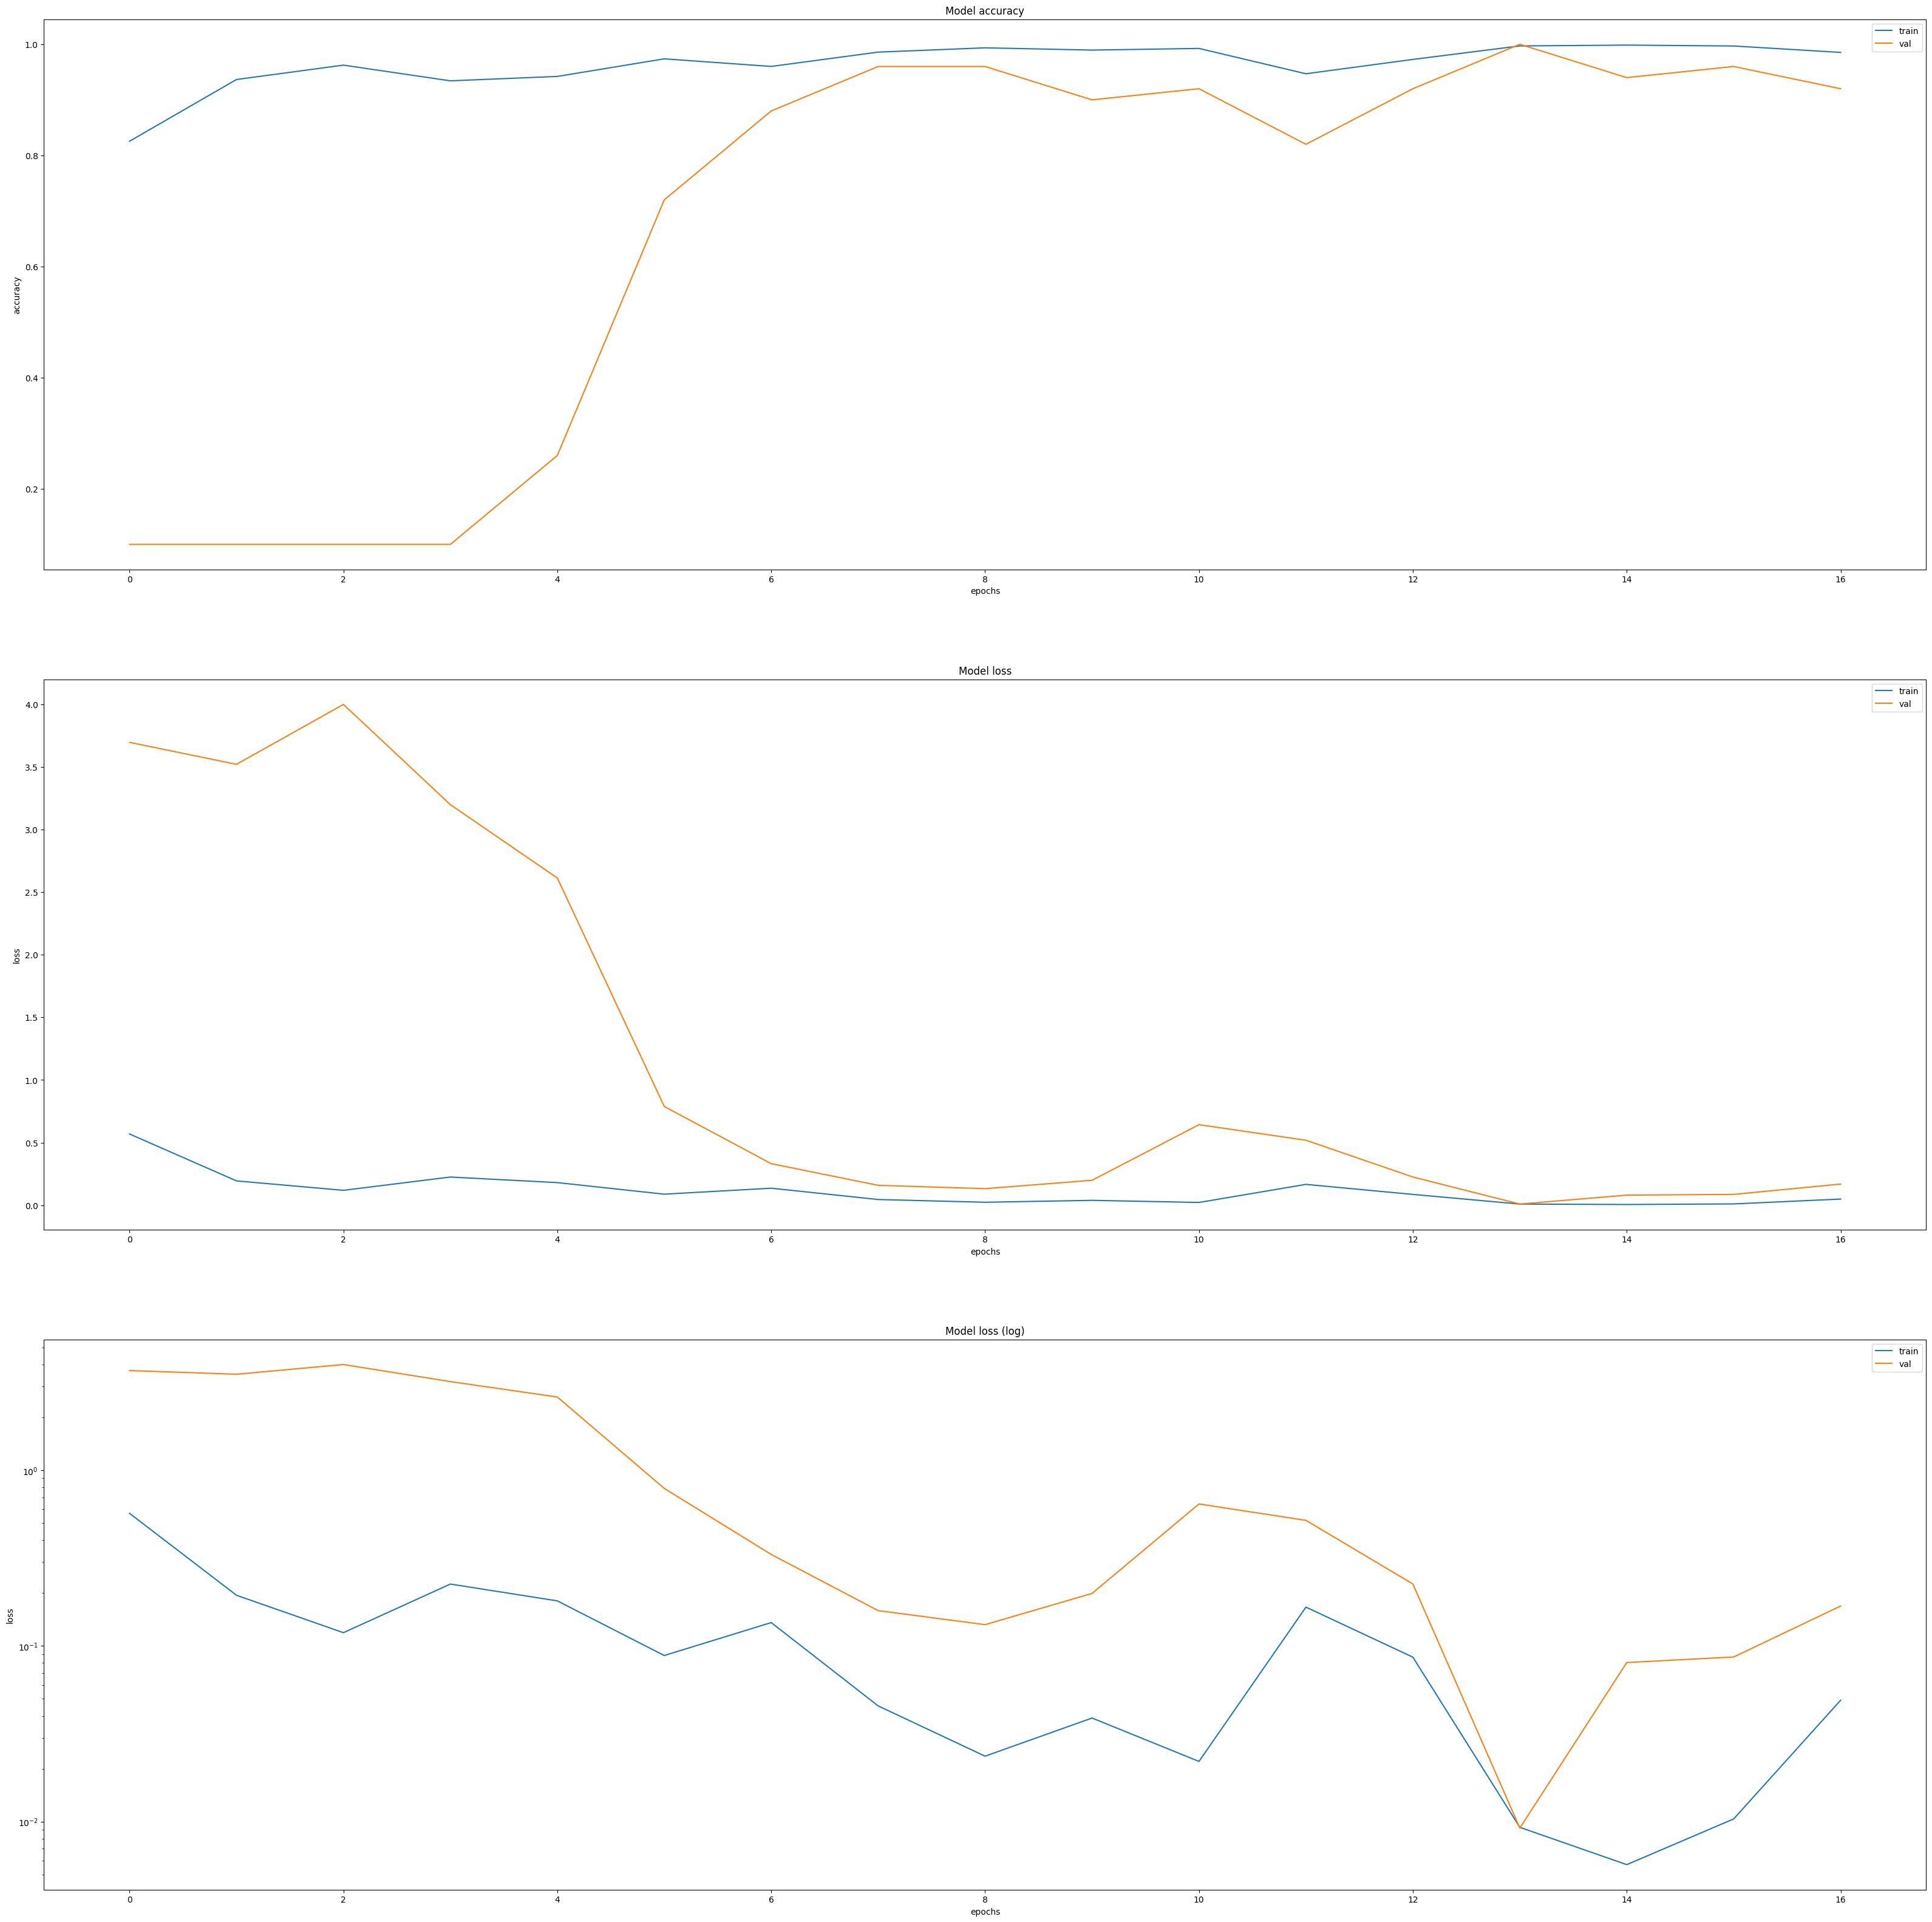

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(40, 40))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Logarithmic loss
metric = "loss"
ax[2].plot(model.history.history[metric])
ax[2].plot(model.history.history["val_" + metric])
ax[2].set_title("Model {} (log)".format(metric))
ax[2].set_xlabel("epochs")
ax[2].set_ylabel(metric)
ax[2].legend(["train", "val"])
ax[2].set_yscale("log")

plt.show()

In [17]:
# (Eventually) reload the minimum val_loss Epoch
import tensorflow as tf
model = tf.keras.models.load_model("C:/Users/ricig/Desktop/Callbacks/save_at_14.keras")

In [18]:
# Inference on the Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')


2/2 [==============================] - 11s 5s/step - loss: 0.0781 - accuracy: 0.9800
Test loss: 0.07806342095136642
Test accuracy: 0.9800000190734863


In [19]:
pred = model.predict(X_test)

In [20]:
print(pred.sum(axis=-1))

[0.9999999  1.         0.9999999  0.99999994 1.         1.
 1.         1.         1.         1.         0.99999994 1.
 0.99999994 0.99999994 1.         1.0000001  1.0000001  1.
 0.99999994 1.         1.0000001  1.         0.99999994 1.
 1.         1.         1.         1.         0.99999994 1.
 1.         1.         1.         1.         0.99999994 0.9999999
 1.0000001  1.         0.99999994 1.         1.         1.
 0.99999994 0.99999994 0.99999994 0.99999994 1.         1.
 1.         1.        ]


In [21]:
pred = np.argmax(pred, axis = -1)
pred

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int64)

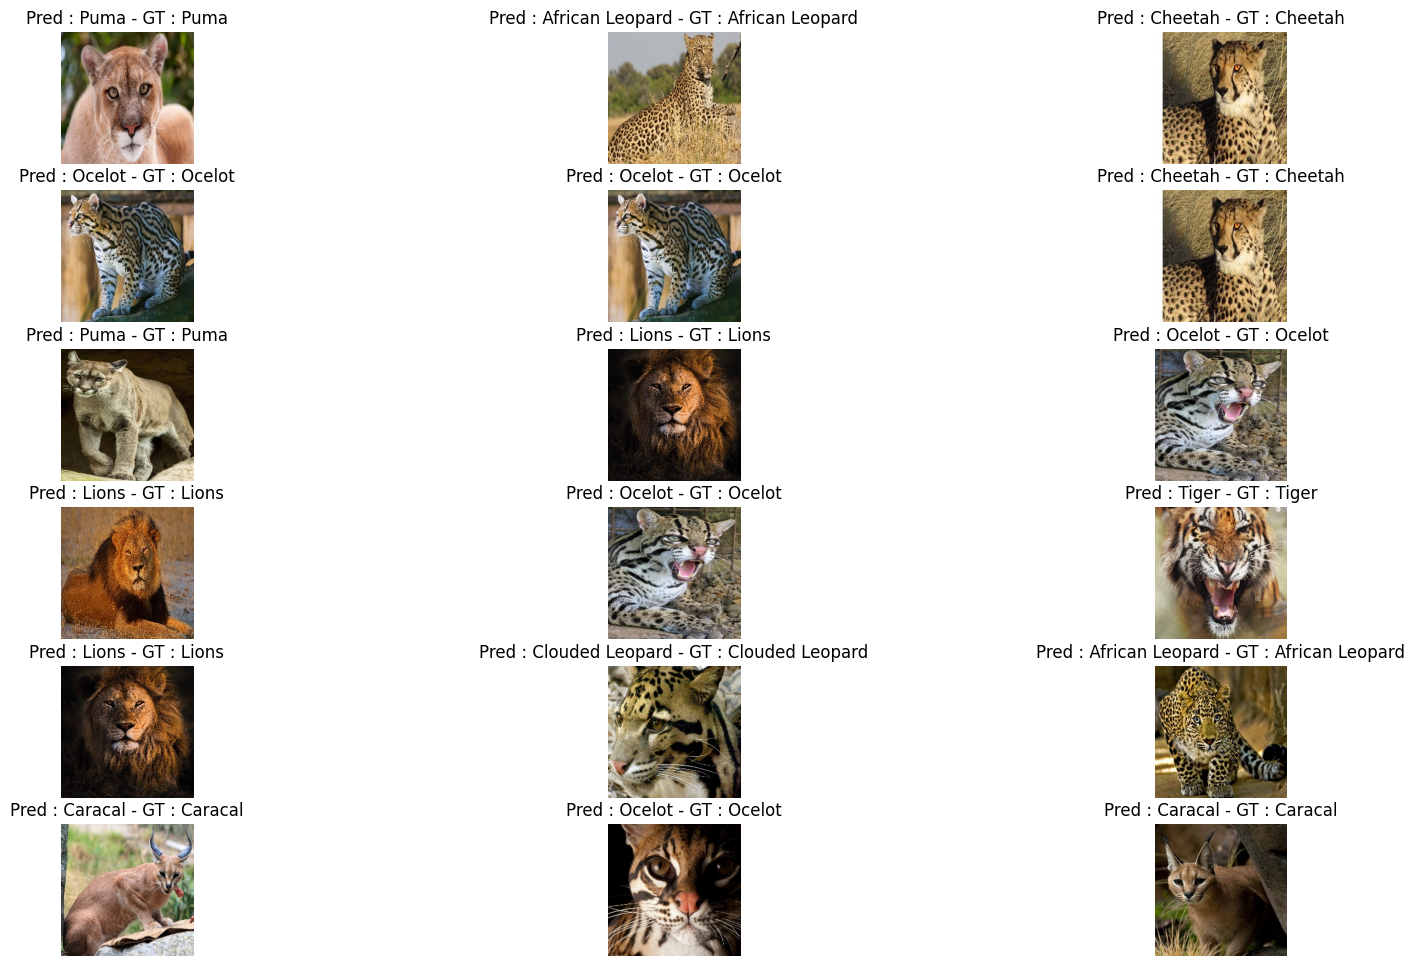

In [22]:
fig, ax = plt.subplots(6, 3, figsize=(20, 12))
ax = ax.ravel()

for i in range(18):
    rand_idx = np.random.randint(0, X_test.shape[0])

    ax[i].set_axis_off()
    
    # Convert the image to 8-bit unsigned integers
    img_8bit = cv2.normalize(X_test[rand_idx], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2RGB)
    
    ax[i].set_title(f"Pred : {labels[pred[rand_idx]]} - GT : {labels[y_test[rand_idx]]}")
    ax[i].imshow(img_rgb, cmap = "gray")


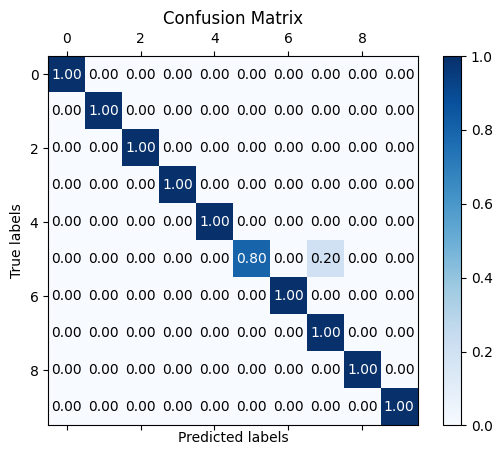

In [23]:
from sklearn.metrics import confusion_matrix

# Use scikit-learn's confusion_matrix function
cm = confusion_matrix(y_test, pred, normalize='true')

# Create a figure and an axis
fig, ax = plt.subplots()

# Create a color map
cax = ax.matshow(cm, cmap=plt.cm.Blues)

# Create a color bar
fig.colorbar(cax)

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Add text annotations to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Use white color for the diagonal and black for others
        color = 'white' if i == j else 'black'
        ax.text(j, i, f'{cm[i, j]:.2f}', ha='center', va='center', color=color)

# Show the plot
plt.show()
